<a href="https://colab.research.google.com/github/HARIPRASATH-R-44/weather-forecasting-and-air-quality-prediction/blob/master/weatherforescasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas.core.describe import DataFrameDescriber
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")
station_day = pd.read_csv("/content/drive/MyDrive/weather/station_day_correctedformat.csv")
station_day.head()
df=station_day
df = df.dropna()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


In [ ]:
df = df.dropna()

In [ ]:
arima_df = station_day[['Date','AQI']]

In [ ]:
arima_df["Date"]= pd.to_datetime(arima_df["Date"])


In [ ]:
arima_df.AQI = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].mean()

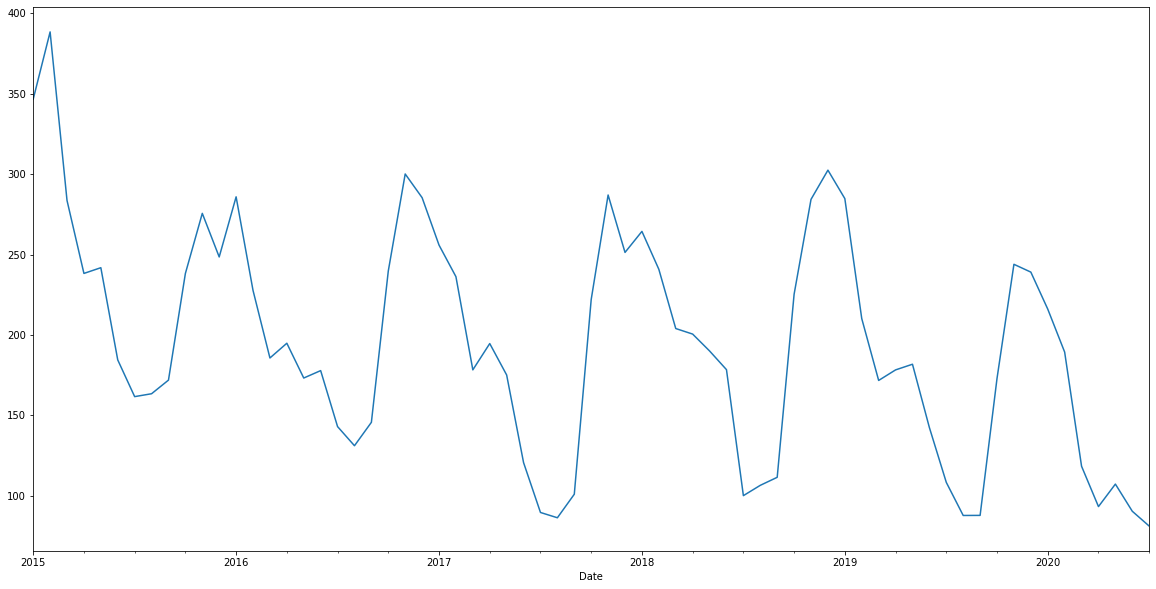

In [ ]:
plt.figure(figsize = (20,10))
ts.plot()
plt.show()

In [ ]:
df.isnull()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106143,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
106144,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
106145,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
106146,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:

mean_val = ts.mean()
ts = ts.replace([np.inf, -np.inf], mean_val)

ts= ts.fillna(method="ffill")
print(ts)

Date
2015-01    346.646154
2015-02    388.518519
2015-03    283.645390
2015-04    238.262136
2015-05    241.826087
              ...    
2020-03    118.297150
2020-04     93.204738
2020-05    107.199669
2020-06     90.298870
2020-07     81.070707
Freq: M, Name: AQI, Length: 67, dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.224505
p-value: 0.662967


In [ ]:
ts_train = ts[:50]
ts_test = ts[50:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error
p = range(0,8)
q = range(0,8)
d = range(0,2)
pqd_combination = list(itertools.product(p,d,q))
error = []
pqd = []

In [ ]:
for i in pqd_combination:
    A_model = ARIMA(ts_train,order= i).fit()
    predict = A_model.predict(len(ts_train),len(ts)-1)
    e = np.sqrt(mean_squared_error(ts_test,predict))
    pqd.append(i)
    error.append(e)

In [ ]:
min = error[0]
index = 0
for i in range(1,len(error)-1):
    if(min > error[i]):
        min = error[i]
        index = i

print(error[index],' => ',pqd[index])

48.48382942412987  =>  (7, 1, 1)


In [ ]:
model_ts = ARIMA(ts_train, order=pqd[index])
model_ts_fit = model_ts.fit()
print(model_ts_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   50
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -241.966
Date:                Sat, 11 Feb 2023   AIC                            501.931
Time:                        04:31:17   BIC                            518.957
Sample:                    01-31-2015   HQIC                           508.391
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7066      0.217      3.257      0.001       0.281       1.132
ar.L2         -0.2553      0.247     -1.036      0.300      -0.739       0.228
ar.L3         -0.1310      0.188     -0.697      0.4

In [ ]:
arima_predict = model_ts_fit.predict(start = len(ts_train),end = len(ts))

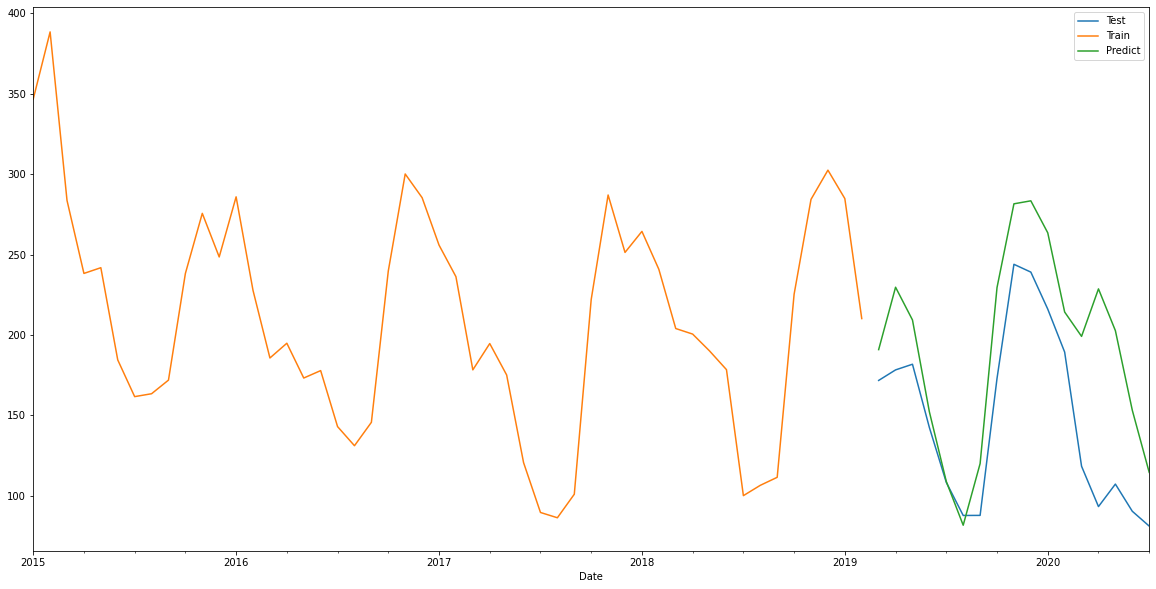

In [ ]:
plt.figure(figsize = (20,10))
ts_test.plot(label = "Test")
ts_train.plot(label = "Train")
predict.plot(label = 'Predict')
plt.legend()
plt.show()